<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Watson Machine Learning

This notebook should be run in a Watson Studio project, using **Default Spark Python** runtime environment. **If you are viewing this in Watson Studio and do not see Python 3.5 with Spark in the upper right corner of your screen, please update the runtime now.** It requires service credentials for the following Cloud services:
  * Watson OpenScale
  * Watson Machine Learning
  
If you have a paid Cloud account, you may also provision a **Databases for PostgreSQL** or **Db2 Warehouse** service to take full advantage of integration with Watson Studio and continuous learning services. If you choose not to provision this paid service, you can use the free internal PostgreSQL storage with OpenScale, but will not be able to configure continuous learning for your model.

The notebook will train, create and deploy a German Credit Risk model, configure OpenScale to monitor that deployment, and inject seven days' worth of historical records and measurements for viewing in the OpenScale Insights dashboard.

### Contents

- [Setup](#setup)
- [Model building and deployment](#model)
- [OpenScale configuration](#openscale)
- [Quality monitor and feedback logging](#quality)
- [Fairness monitoring and explanations](#fairness)
- [Custom monitors and metrics](#custom)
- [Payload analytics](#analytics)
- [Historical data](#historical)

# Setup <a name="setup"></a>

## Spark check

In [1]:
try:
    from pyspark.sql import SparkSession
except:
    print('Error: Spark runtime is missing. If you are using Watson Studio change the notebook runtime to Spark.')
    raise 

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190605094250-0001
KERNEL_ID = dace49ae-0b73-4ada-94e3-9c57eef7231c


## Package installation

In [2]:
!rm -rf /home/spark/shared/user-libs/python3/*

!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade watson-machine-learning-client | tail -n 1
!pip install --upgrade numpy --no-cache | tail -n 1
!pip install --upgrade SciPy --no-cache | tail -n 1
!pip install lime --no-cache | tail -n 1
!pip install pixiedust | tail -n 1

tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
spyder 3.3.3 requires pyqt5<=5.12; python_version >= "3", which is not installed.
ibm-cos-sdk-core 2.4.4 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.3 which is incompatible.
botocore 1.12.82 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.3 which is incompatible.
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
spyder 3.3.3 requires pyqt5<=5.12; python_version >= "3", which is not installed.
ibm-cos-sdk-core 2.4.4 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.3 which is incompatible.
botocore 1.12.82 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.3 which is incompatible.
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not ins

## Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/watson-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [3]:
CLOUD_API_KEY = "PASTE HERE"

In [4]:
# The code was removed by Watson Studio for sharing.

Next you will need credentials for Watson Machine Learning. If you already have a WML instance, you may use credentials for it. To provision a new Lite instance of WML, use the [Cloud catalog](https://cloud.ibm.com/catalog/services/machine-learning), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your WML credentials into the cell below.

In [5]:
WML_CREDENTIALS = {
    "apikey": "key",
    "iam_apikey_description": "description",
    "iam_apikey_name": "auto-generated-apikey",
    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::",
    "instance_id": "instance_id",
    "password": "password",
    "url": "https://us-south.ml.cloud.ibm.com",
    "username": "username"
}

In [6]:
# The code was removed by Watson Studio for sharing.

This tutorial can use Databases for PostgreSQL, Db2 Warehouse, or a free internal verison of PostgreSQL to create a datamart for OpenScale.

If you have previously configured OpenScale, it will use your existing datamart, and not interfere with any models you are currently monitoring. Do not update the cell below.

If you do not have a paid Cloud account or would prefer not to provision this paid service, you may use the free internal PostgreSQL service with OpenScale. Do not update the cell below.

To provision a new instance of Db2 Warehouse, locate [Db2 Warehouse in the Cloud catalog](https://cloud.ibm.com/catalog/services/db2-warehouse), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your Db2 Warehouse credentials into the cell below.

To provision a new instance of Databases for PostgreSQL, locate [Databases for PostgreSQL in the Cloud catalog](https://cloud.ibm.com/catalog/services/databases-for-postgresql), give your service a name, and click **Create**. Once your instance is created, click the **Service Credentials** link on the left side of the screen. Click the **New credential** button, give your credentials a name, and click **Add**. Your new credentials can be accessed by clicking the **View credentials** button. Copy and paste your Databases for PostgreSQL credentials into the cell below.

In [7]:
DB_CREDENTIALS = None

__If you previously configured OpenScale to use the free internal version of PostgreSQL, you can switch to a new datamart using a paid database service.__ If you would like to delete the internal PostgreSQL configuration and create a new one using service credentials supplied in the cell above, set the __KEEP_MY_INTERNAL_POSTGRES__ variable below to __False__ below. In this case, the notebook will remove your existing internal PostgreSQL datamart and create a new one with the supplied credentials. __*NO DATA MIGRATION WILL OCCUR.*__

In [8]:
KEEP_MY_INTERNAL_POSTGRES = True

## Run the notebook

At this point, the notebook is ready to run. You can either run the cells one at a time, or click the **Kernel** option above and select **Restart and Run All** to run all the cells.

# Model building and deployment <a name="model"></a>

In this section you will learn how to train Spark MLLib model and next deploy it as web-service using Watson Machine Learning service.

## Load the training data from github

In [9]:
!rm german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv

--2019-06-05 09:45:47--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: 'german_credit_data_biased_training.csv'

german_credit_data_ 100%[===================>] 673.46K  --.-KB/s    in 0.02s   

2019-06-05 09:45:47 (26.6 MB/s) - 'german_credit_data_biased_training.csv' saved [689622/689622]



In [10]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
pd_data = pd.read_csv("german_credit_data_biased_training.csv", sep=",", header=0)
df_data = spark.read.csv(path="german_credit_data_biased_training.csv", sep=",", header=True, inferSchema=True)
df_data.head()

Row(CheckingStatus='0_to_200', LoanDuration=31, CreditHistory='credits_paid_to_date', LoanPurpose='other', LoanAmount=1889, ExistingSavings='100_to_500', EmploymentDuration='less_1', InstallmentPercent=3, Sex='female', OthersOnLoan='none', CurrentResidenceDuration=3, OwnsProperty='savings_insurance', Age=32, InstallmentPlans='none', Housing='own', ExistingCreditsCount=1, Job='skilled', Dependents=1, Telephone='none', ForeignWorker='yes', Risk='No Risk')

## Explore data

In [11]:
df_data.printSchema()

root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = true)



In [12]:
print("Number of records: " + str(df_data.count()))

Number of records: 5000


## Visualize data with pixiedust

In [13]:
import pixiedust

Pixiedust database opened successfully



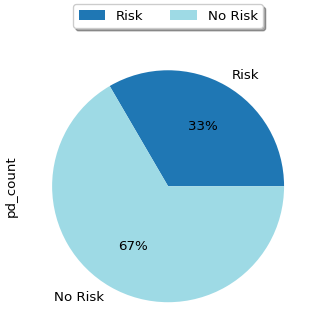

In [ ]:
display(df_data)

## Create a model

In [15]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

MODEL_NAME = "Spark German Risk Model - Final"
DEPLOYMENT_NAME = "Spark German Risk Deployment - Final"

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

spark_df.printSchema()

Number of records for training: 4016
Number of records for evaluation: 984
root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = 

The code below creates a Random Forest Classifier with Spark, setting up string indexers for the categorical features and the label column. Finally, this notebook creates a pipeline including the indexers and the model, and does an initial Area Under ROC evaluation of the model.

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

si_CheckingStatus = StringIndexer(inputCol = 'CheckingStatus', outputCol = 'CheckingStatus_IX')
si_CreditHistory = StringIndexer(inputCol = 'CreditHistory', outputCol = 'CreditHistory_IX')
si_LoanPurpose = StringIndexer(inputCol = 'LoanPurpose', outputCol = 'LoanPurpose_IX')
si_ExistingSavings = StringIndexer(inputCol = 'ExistingSavings', outputCol = 'ExistingSavings_IX')
si_EmploymentDuration = StringIndexer(inputCol = 'EmploymentDuration', outputCol = 'EmploymentDuration_IX')
si_Sex = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_IX')
si_OthersOnLoan = StringIndexer(inputCol = 'OthersOnLoan', outputCol = 'OthersOnLoan_IX')
si_OwnsProperty = StringIndexer(inputCol = 'OwnsProperty', outputCol = 'OwnsProperty_IX')
si_InstallmentPlans = StringIndexer(inputCol = 'InstallmentPlans', outputCol = 'InstallmentPlans_IX')
si_Housing = StringIndexer(inputCol = 'Housing', outputCol = 'Housing_IX')
si_Job = StringIndexer(inputCol = 'Job', outputCol = 'Job_IX')
si_Telephone = StringIndexer(inputCol = 'Telephone', outputCol = 'Telephone_IX')
si_ForeignWorker = StringIndexer(inputCol = 'ForeignWorker', outputCol = 'ForeignWorker_IX')

In [17]:
si_Label = StringIndexer(inputCol="Risk", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

In [18]:
va_features = VectorAssembler(inputCols=["CheckingStatus_IX", "CreditHistory_IX", "LoanPurpose_IX", "ExistingSavings_IX", "EmploymentDuration_IX", "Sex_IX", \
                                         "OthersOnLoan_IX", "OwnsProperty_IX", "InstallmentPlans_IX", "Housing_IX", "Job_IX", "Telephone_IX", "ForeignWorker_IX", \
                                         "LoanDuration", "LoanAmount", "InstallmentPercent", "CurrentResidenceDuration", "LoanDuration", "Age", "ExistingCreditsCount", \
                                         "Dependents"], outputCol="features")

In [19]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_CheckingStatus, si_CreditHistory, si_EmploymentDuration, si_ExistingSavings, si_ForeignWorker, si_Housing, si_InstallmentPlans, si_Job, si_LoanPurpose, si_OthersOnLoan,\
                               si_OwnsProperty, si_Sex, si_Telephone, si_Label, va_features, classifier, label_converter])
model = pipeline.fit(train_data)

In [20]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.714326


## Publish the model

In this section, the notebook uses the supplied Watson Machine Learning credentials to save the model (including the pipeline) to the WML instance. Previous versions of the model are removed so that the notebook can be run again, resetting all data for another demo.

In [21]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

/home/spark/shared/user-libs/python3/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Remove existing model and deployment

In [22]:
model_deployment_ids = wml_client.deployments.get_uids()
for deployment_id in model_deployment_ids:
    deployment = wml_client.deployments.get_details(deployment_id)
    model_id = deployment['entity']['deployable_asset']['guid']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

Deleting deployment id d628aff8-b8aa-42ec-803e-c0d185a99e49
Deleting model id 145a1365-cb75-465e-8210-1858adbae7f6
------------------------------------  ------------------------------------  ------------------------  -----------------
GUID                                  NAME                                  CREATED                   FRAMEWORK
a3583b91-2a7c-4817-bb95-293831c7f183  AIOS Spark German Risk model          2019-05-29T14:20:59.828Z  mllib-2.1
965e5b42-9cca-4141-8881-a17b5f75a91b  AIOS Spark German Risk model          2019-05-29T13:18:27.395Z  mllib-2.1
e6ffbb1e-53a6-40f3-b190-2d11fdbe458a  AIOS Spark German Risk model          2019-05-29T11:49:07.583Z  mllib-2.1
d6293dce-3e73-4e3d-b96d-a4c532c78596  AIOS Spark German Risk model          2019-05-29T11:39:48.770Z  mllib-2.1
10ff3963-f81d-46d6-9e52-64d6530f27a9  AIOS Spark German Risk model          2019-05-29T11:36:26.465Z  mllib-2.1
32eec06f-de31-4a08-b329-c659a05826f7  AIOS Spark German Risk model          2019-05-29T10:59:

In [23]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    wml_client.repository.ModelMetaNames.EVALUATION_METHOD: "binary",
    wml_client.repository.ModelMetaNames.EVALUATION_METRICS: [
        {
           "name": "areaUnderROC",
           "value": area_under_curve,
           "threshold": 0.7
        }
    ]
}

In [24]:
wml_models = wml_client.repository.get_details()
model_uid = None
for model_in in wml_models['models']['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")

    published_model_details = wml_client.repository.store_model(model=model, meta_props=model_props, training_data=train_data, pipeline=pipeline)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")

Storing model ...


/home/spark/shared/user-libs/python3/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Done


In [25]:
model_uid

'1516b304-44cb-4950-bc67-827ad7f219f3'

## Deploy the model

The next section of the notebook deploys the model as a RESTful web service in Watson Machine Learning. The deployed model will have a scoring URL you can use to send data to the model for predictions.

In [26]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")

    deployment = wml_client.deployments.create(artifact_uid=model_uid, name=DEPLOYMENT_NAME, asynchronous=False)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '1516b304-44cb-4950-bc67-827ad7f219f3' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='280ac486-14a8-4d4a-95ca-0950498b0523'
------------------------------------------------------------------------------------------------


Model id: 1516b304-44cb-4950-bc67-827ad7f219f3
Deployment id: 280ac486-14a8-4d4a-95ca-0950498b0523


# Configure OpenScale <a name="openscale"></a>

The notebook will now import the necessary libraries and set up a Python OpenScale client.

In [27]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

### Get Watson OpenScale GUID

Each instance of OpenScale has a unique ID. We can get this value using the Cloud API key specified at the beginning of the notebook.

In [28]:
import requests
from ibm_ai_openscale.utils import get_instance_guid


WOS_GUID = get_instance_guid(api_key=CLOUD_API_KEY)
WOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if WOS_GUID is None:
    print('Watson OpenScale GUID NOT FOUND')
else:
    print(WOS_GUID)

cacaf1bc-1285-46da-ba9a-49464bc683a3


In [29]:
ai_client = APIClient(aios_credentials=WOS_CREDENTIALS)
ai_client.version

'2.1.7'

## Create schema and datamart

### Set up datamart

Watson OpenScale uses a database to store payload logs and calculated metrics. If database credentials were **not** supplied above, the notebook will use the free, internal lite database. If database credentials were supplied, the datamart will be created there **unless** there is an existing datamart **and** the **KEEP_MY_INTERNAL_POSTGRES** variable is set to **True**. If an OpenScale datamart exists in Db2 or PostgreSQL, the existing datamart will be used and no data will be overwritten.

Prior instances of the German Credit model will be removed from OpenScale monitoring.

In [31]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    if 'internal_database' in data_mart_details and data_mart_details['internal_database']:
        if KEEP_MY_INTERNAL_POSTGRES:
            print('Using existing internal datamart.')
        else:
            if DB_CREDENTIALS is None:
                print('No postgres credentials supplied. Using existing internal datamart')
            else:
                print('Switching to external datamart')
                ai_client.data_mart.delete(force=True)
                ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
    else:
        print('Using existing external datamart')
except:
    if DB_CREDENTIALS is None:
        print('Setting up internal datamart')
        ai_client.data_mart.setup(internal_db=True)
    else:
        print('Setting up external datamart')
        try:
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
        except:
            print('Setup failed, trying Db2 setup')
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS, schema=DB_CREDENTIALS['username'])
    

Setting up internal datamart


In [32]:
data_mart_details = ai_client.data_mart.get_details()
data_mart_details

{'internal_database': True,
 'service_instance_crn': 'crn:v1:bluemix:public:aiopenscale:us-south:a/bc6f89c9dbf0a21338f4ee6fa02cf6cf:cacaf1bc-1285-46da-ba9a-49464bc683a3::',
 'status': {'state': 'active'},
 'database_configuration': {},
 'internal_database_pool': 'compose-psql'}

## Bind machine learning engines

Watson OpenScale needs to be bound to the Watson Machine Learning instance to capture payload data into and out of the model. If this binding already exists, this code will output a warning message and use the existing binding.

**Note:** You can bind more than one engine instance if needed by calling `ai_client.data_mart.bindings.add` method. Next, you can refer to particular binding using `binding_uid`.

In [33]:
binding_uid = ai_client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(WML_CREDENTIALS))
if binding_uid is None:
    binding_uid = ai_client.data_mart.bindings.get_details()['service_bindings'][0]['metadata']['guid']
bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

a73bf76d-a663-448a-b771-4f651f73d54e,WML instance,watson_machine_learning,2019-06-05T09:49:19.056Z


In [34]:
print(binding_uid)

a73bf76d-a663-448a-b771-4f651f73d54e


In [35]:
ai_client.data_mart.bindings.list_assets()

1516b304-44cb-4950-bc67-827ad7f219f3,Spark German Risk Model - Final,2019-06-05T09:47:46.690Z,model,mllib-2.3,a73bf76d-a663-448a-b771-4f651f73d54e,False
a3583b91-2a7c-4817-bb95-293831c7f183,AIOS Spark German Risk model,2019-05-29T14:21:08.875Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
965e5b42-9cca-4141-8881-a17b5f75a91b,AIOS Spark German Risk model,2019-05-29T13:18:36.510Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
e6ffbb1e-53a6-40f3-b190-2d11fdbe458a,AIOS Spark German Risk model,2019-05-29T11:49:16.526Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
d6293dce-3e73-4e3d-b96d-a4c532c78596,AIOS Spark German Risk model,2019-05-29T11:39:57.816Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
10ff3963-f81d-46d6-9e52-64d6530f27a9,AIOS Spark German Risk model,2019-05-29T11:36:35.458Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
32eec06f-de31-4a08-b329-c659a05826f7,AIOS Spark German Risk model,2019-05-29T11:00:04.443Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
011cfea9-4e65-4e9a-97be-011dd5a68c72,AIOS Spark German Risk model,2019-05-27T13:29:15.866Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
29d1c6e1-60b1-438a-9754-2788e3aa9bf6,AIOS Spark German Risk model,2019-05-27T09:57:41.912Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
15eca736-b889-494c-9aa7-374cd3997aff,AIOS Spark German Risk model,2019-05-24T10:39:58.847Z,model,mllib-2.1,a73bf76d-a663-448a-b771-4f651f73d54e,False
cf689555-3b4f-4613-a8d0-4e9706bc8fe7,diabetes regression,2019-05-23T07:19:18.801Z,model,scikit-learn-0.19,a73bf76d-a663-448a-b771-4f651f73d54e,False


## Subscriptions

### Remove existing credit risk subscriptions

This code removes previous subscriptions to the German Credit model to refresh the monitors with the new model and new data.

In [36]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

This code creates the model subscription in OpenScale using the Python client API. Note that we need to provide the model unique identifier, and some information about the model itself.

In [37]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='Risk',
    prediction_column='predictedLabel',
    probability_column='probability',
    feature_columns = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"],
    categorical_columns = ["CheckingStatus","CreditHistory","LoanPurpose","ExistingSavings","EmploymentDuration","Sex","OthersOnLoan","OwnsProperty","InstallmentPlans","Housing","Job","Telephone","ForeignWorker"]
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)

Get subscription list

In [38]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

1516b304-44cb-4950-bc67-827ad7f219f3,Spark German Risk Model - Final,model,a73bf76d-a663-448a-b771-4f651f73d54e,2019-06-05T09:49:36.668Z


In [39]:
subscription_details = subscription.get_details()

### Score the model so we can configure monitors

Now that the WML service has been bound and the subscription has been created, we need to send a request to the model before we configure OpenScale. This allows OpenScale to create a payload log in the datamart with the correct schema, so it can capture data coming into and out of the model. First, the code gets the model deployment's endpoint URL, and then sends a few records for predictions.

In [40]:
credit_risk_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        credit_risk_scoring_endpoint = deployment['entity']['scoring_url']
        
print(credit_risk_scoring_endpoint)

280ac486-14a8-4d4a-95ca-0950498b0523
https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/deployments/280ac486-14a8-4d4a-95ca-0950498b0523/online


In [41]:
fields = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"]
values = [
  ["no_checking",13,"credits_paid_to_date","car_new",1343,"100_to_500","1_to_4",2,"female","none",3,"savings_insurance",46,"none","own",2,"skilled",1,"none","yes"],
  ["no_checking",24,"prior_payments_delayed","furniture",4567,"500_to_1000","1_to_4",4,"male","none",4,"savings_insurance",36,"none","free",2,"management_self-employed",1,"none","yes"],
  ["0_to_200",26,"all_credits_paid_back","car_new",863,"less_100","less_1",2,"female","co-applicant",2,"real_estate",38,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",14,"no_credits","car_new",2368,"less_100","1_to_4",3,"female","none",3,"real_estate",29,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",4,"no_credits","car_new",250,"less_100","unemployed",2,"female","none",3,"real_estate",23,"none","rent",1,"management_self-employed",1,"none","yes"],
  ["no_checking",17,"credits_paid_to_date","car_new",832,"100_to_500","1_to_4",2,"male","none",2,"real_estate",42,"none","own",1,"skilled",1,"none","yes"],
  ["no_checking",33,"outstanding_credit","appliances",5696,"unknown","greater_7",4,"male","co-applicant",4,"unknown",54,"none","free",2,"skilled",1,"yes","yes"],
  ["0_to_200",13,"prior_payments_delayed","retraining",1375,"100_to_500","4_to_7",3,"male","none",3,"real_estate",37,"none","own",2,"management_self-employed",1,"none","yes"]
]

payload_scoring = {"fields": fields,"values": values}
scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)

print('Single record scoring result:', '\n fields:', scoring_response['fields'], '\n values: ', scoring_response['values'][0])

Single record scoring result: 
 fields: ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'CheckingStatus_IX', 'CreditHistory_IX', 'EmploymentDuration_IX', 'ExistingSavings_IX', 'ForeignWorker_IX', 'Housing_IX', 'InstallmentPlans_IX', 'Job_IX', 'LoanPurpose_IX', 'OthersOnLoan_IX', 'OwnsProperty_IX', 'Sex_IX', 'Telephone_IX', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel'] 
 values:  ['no_checking', 13, 'credits_paid_to_date', 'car_new', 1343, '100_to_500', '1_to_4', 2, 'female', 'none', 3, 'savings_insurance', 46, 'none', 'own', 2, 'skilled', 1, 'none', 'yes', 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, [21, [1, 3, 5, 13, 14, 15, 16, 17, 18, 19, 20], [1.0, 1.0, 1.0, 13

# Quality monitoring and feedback logging <a name="quality"></a>

## Enable quality monitoring

The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it turns on the quality (accuracy) monitor and sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second paramater supplied, min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

In [42]:
time.sleep(10)
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

## Feedback logging

The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [43]:
!rm additional_feedback_data.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json

rm: cannot remove 'additional_feedback_data.json': No such file or directory
--2019-06-05 09:49:53--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16506 (16K) [text/plain]
Saving to: 'additional_feedback_data.json'

additional_feedback 100%[===================>]  16.12K  --.-KB/s    in 0s      

2019-06-05 09:49:54 (139 MB/s) - 'additional_feedback_data.json' saved [16506/16506]



In [44]:
with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
    
subscription.feedback_logging.store(additional_feedback_data['data'])

In [45]:
subscription.feedback_logging.show_table()

less_0,10,all_credits_paid_back,car_new,250,500_to_1000,4_to_7,3,male,none,2,real_estate,23,none,rent,1,skilled,1,none,yes,No Risk,2019-06-05 09:49:54.784491+00:00
no_checking,23,prior_payments_delayed,appliances,6964,100_to_500,4_to_7,4,female,none,3,car_other,39,none,own,1,skilled,1,none,yes,Risk,2019-06-05 09:49:54.784491+00:00
0_to_200,30,outstanding_credit,appliances,3464,100_to_500,greater_7,3,male,guarantor,4,savings_insurance,51,stores,free,1,skilled,1,yes,yes,Risk,2019-06-05 09:49:54.784491+00:00
no_checking,23,outstanding_credit,car_used,2681,500_to_1000,greater_7,4,male,none,3,car_other,33,stores,free,1,unskilled,1,yes,yes,No Risk,2019-06-05 09:49:54.784491+00:00
0_to_200,18,prior_payments_delayed,furniture,1673,less_100,1_to_4,2,male,none,3,car_other,30,none,own,2,skilled,1,none,yes,Risk,2019-06-05 09:49:54.784491+00:00
no_checking,44,outstanding_credit,radio_tv,3476,unknown,greater_7,4,male,co-applicant,4,unknown,60,none,free,2,skilled,2,yes,yes,Risk,2019-06-05 09:49:54.784491+00:00
less_0,8,no_credits,education,803,less_100,unemployed,1,male,none,1,savings_insurance,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-06-05 09:49:54.784491+00:00
0_to_200,7,all_credits_paid_back,car_new,250,less_100,unemployed,1,male,none,1,real_estate,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-06-05 09:49:54.784491+00:00
0_to_200,33,credits_paid_to_date,radio_tv,3548,100_to_500,1_to_4,3,male,none,4,car_other,28,none,own,2,skilled,1,yes,yes,Risk,2019-06-05 09:49:54.784491+00:00
no_checking,24,prior_payments_delayed,retraining,4158,100_to_500,greater_7,3,female,none,2,savings_insurance,35,stores,own,1,unskilled,2,none,yes,Risk,2019-06-05 09:49:54.784491+00:00


In [46]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 97bf5074-779b-413c-a005-c33e9cf53767 




initializing.
running
completed

---------------------------
 Successfully finished run 
---------------------------




In [47]:
subscription.quality_monitoring.show_table()

2019-06-05 09:49:58.089000+00:00,true_positive_rate,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.42424242424242425,,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:49:58.089000+00:00,area_under_roc,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.6813519813519814,0.7,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:49:58.089000+00:00,precision,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.7777777777777778,,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:49:58.089000+00:00,f1_measure,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.5490196078431373,,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:49:58.089000+00:00,accuracy,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.7653061224489796,,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:49:58.089000+00:00,log_loss,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.4374274768104465,,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:49:58.089000+00:00,false_positive_rate,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.06153846153846154,,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:49:58.089000+00:00,area_under_pr,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.6508108293822579,,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:49:58.089000+00:00,recall,b911aefe-2e16-48d3-80e2-4d7c1574c074,0.42424242424242425,,,model_type: original,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523


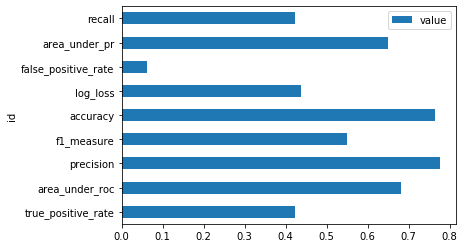

In [48]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

In [49]:
ai_client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'subscription': {'subscription_id': '1516b304-44cb-4950-bc67-827ad7f219f3',
    'url': '/v1/data_marts/cacaf1bc-1285-46da-ba9a-49464bc683a3/service_bindings/a73bf76d-a663-448a-b771-4f651f73d54e/subscriptions/1516b304-44cb-4950-bc67-827ad7f219f3'},
   'asset': {'name': 'Spark German Risk Model - Final',
    'asset_id': '1516b304-44cb-4950-bc67-827ad7f219f3',
    'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/published_models/1516b304-44cb-4950-bc67-827ad7f219f3',
    'asset_type': 'model',
    'created_at': '2019-06-05T09:47:46.690Z'},
   'deployment': {'name': 'Spark German Risk Deployment - Final',
    'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/deployments/280ac486-14a8-4d4a-95ca-0950498b0523',
    'deployment_type': 'online',
    'scoring_endpoint': {'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/deployments/28

# Fairness monitoring and explanations <a name="fairness"></a>

The code below configures fairness monitoring for our model. It turns on monitoring for two features, Sex and Age. In each case, we must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 95%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 200 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide the dataframe containing the data.

In [50]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26,75]], minority=[[18,25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=200,
            training_data=pd_data
        )

## Score the model again now that monitoring is configured

This next section randomly selects 200 records from the data feed and sends those records to the model for predictions. This is enough to exceed the minimum threshold for records set in the previous section, which allows OpenScale to begin calculating fairness.

In [51]:
!rm german_credit_feed.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_feed.json

rm: cannot remove 'german_credit_feed.json': No such file or directory
--2019-06-05 09:50:20--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_feed.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3076547 (2.9M) [text/plain]
Saving to: 'german_credit_feed.json'

german_credit_feed. 100%[===================>]   2.93M  --.-KB/s    in 0.06s   

2019-06-05 09:50:21 (50.9 MB/s) - 'german_credit_feed.json' saved [3076547/3076547]



Score 200 randomly chosen records

In [52]:
import random

with open('german_credit_feed.json', 'r') as scoring_file:
    scoring_data = json.load(scoring_file)

fields = scoring_data['fields']
values = []
for _ in range(200):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}

scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)
time.sleep(5)

## Run fairness monitor

Kick off a fairness monitor run on current data. The monitor runs hourly, but can be manually initiated using the Python client, the REST API, or the graphical user interface.

In [53]:
run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=280ac486-14a8-4d4a-95ca-0950498b0523 




RUNNING....
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [54]:
time.sleep(10)

subscription.fairness_monitoring.show_table()

2019-06-05 09:50:28.885715+00:00,Sex,female,True,0.933,69.5,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523,
2019-06-05 09:50:28.885715+00:00,Age,"[18, 25]",False,0.995,76.85950413223141,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523,


## Configure Explainability

Finally, we provide OpenScale with the training data to enable and configure the explainability features.

In [55]:
from ibm_ai_openscale.supporting_classes import *

subscription.explainability.enable(training_data=pd_data)

In [56]:
explainability_details = subscription.explainability.get_details()

## Run explanation for sample record

In [57]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'].values[0]

print(transaction_id)

4fb651304c127cd0a8075037c41519ab-1


In [58]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for 4fb651304c127cd0a8075037c41519ab-1 




in_progress..............
finished

---------------------------
 Successfully finished run 
---------------------------




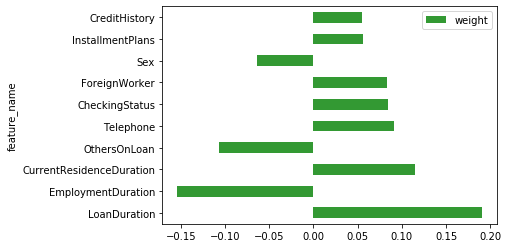

In [59]:
explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

# Custom monitors and metrics <a name="custom"></a>

## Register custom monitor

In [60]:
def get_definition(monitor_name):
    monitors_definitions = ai_client.data_mart.monitors.get_details()['monitor_definitions']
    
    for definition in monitors_definitions:
        if monitor_name == definition['entity']['name']:
            return definition
    
    return None

In [61]:
from ibm_ai_openscale.supporting_classes import Metric, Tag

monitor_name = 'my model performance'
metrics = [Metric(name='sensitivity', lower_limit_default=0.8), Metric(name='specificity', lower_limit_default=0.75)]
tags = [Tag(name='region', description='customer geographical region')]

existing_definition = get_definition(monitor_name)

if existing_definition is None:
    my_monitor = ai_client.data_mart.monitors.add(name=monitor_name, metrics=metrics, tags=tags)
else:
    my_monitor = existing_definition

### List monitors

### Get monitors uids and details

In [62]:
monitor_uid = my_monitor['metadata']['guid']

print(monitor_uid)

my_model_performance


In [63]:
my_monitor = ai_client.data_mart.monitors.get_details(monitor_uid=monitor_uid)
print('monitor definition details', my_monitor)

monitor definition details {'metadata': {'guid': 'my_model_performance', 'url': '/v1/data_marts/cacaf1bc-1285-46da-ba9a-49464bc683a3/monitor_definitions/my_model_performance', 'created_at': '2019-06-05T09:52:43.384Z'}, 'entity': {'name': 'my model performance', 'metrics': [{'id': 'sensitivity', 'name': 'sensitivity', 'thresholds': [{'type': 'lower_limit', 'default': 0.8}], 'required': True}, {'id': 'specificity', 'name': 'specificity', 'thresholds': [{'type': 'lower_limit', 'default': 0.75}], 'required': True}], 'tags': [{'id': 'region', 'name': 'region', 'description': 'customer geographical region', 'required': True}]}}


## Enable custom monitor for subscription

In [64]:
from ibm_ai_openscale.supporting_classes import Threshold

thresholds = [Threshold(metric_uid='sensitivity', lower_limit=0.9)]
subscription.monitoring.enable(monitor_uid=monitor_uid, thresholds=thresholds)

### Get monitor configuration details

In [65]:
subscription.monitoring.get_details(monitor_uid=monitor_uid)

{'enabled': True,
 'thresholds': [{'metric_id': 'sensitivity',
   'type': 'lower_limit',
   'value': 0.9}],
 'monitor_definition': {'metadata': {'guid': 'my_model_performance',
   'url': '/v1/data_marts/cacaf1bc-1285-46da-ba9a-49464bc683a3/monitor_definitions/my_model_performance',
   'created_at': '2019-06-05T09:52:43.384Z'},
  'entity': {'name': 'my model performance',
   'metrics': [{'id': 'sensitivity',
     'name': 'sensitivity',
     'thresholds': [{'type': 'lower_limit', 'default': 0.9}],
     'required': True},
    {'id': 'specificity', 'name': 'specificity', 'required': True}],
   'tags': [{'id': 'region',
     'name': 'region',
     'description': 'customer geographical region',
     'required': True}]}}}

## Storing custom metrics

In [66]:
metrics = {"specificity": 0.78, "sensitivity": 0.67, "region": "us-south"}

subscription.monitoring.store_metrics(monitor_uid=monitor_uid, metrics=metrics)

### List and get custom metrics

In [67]:
time.sleep(5)

subscription.monitoring.show_table(monitor_uid=monitor_uid)

2019-06-05 09:52:43.707389+00:00,sensitivity,2a373154-b6b3-420d-a881-38ff7be26ccc,0.67,0.9,,region: us-south,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523
2019-06-05 09:52:43.707389+00:00,specificity,2a373154-b6b3-420d-a881-38ff7be26ccc,0.78,,,region: us-south,a73bf76d-a663-448a-b771-4f651f73d54e,1516b304-44cb-4950-bc67-827ad7f219f3,280ac486-14a8-4d4a-95ca-0950498b0523


In [68]:
custom_metrics = subscription.monitoring.get_metrics(monitor_uid=monitor_uid, deployment_uid='credit')
custom_metrics

[{'asset_id': '1516b304-44cb-4950-bc67-827ad7f219f3',
  'binding_id': 'a73bf76d-a663-448a-b771-4f651f73d54e',
  'tags': [{'id': 'region', 'value': 'us-south'}],
  'ts': '2019-06-05T09:52:43.707389Z',
  'measurement_id': '2a373154-b6b3-420d-a881-38ff7be26ccc',
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': '1516b304-44cb-4950-bc67-827ad7f219f3',
  'metrics': [{'lower_limit': 0.9, 'id': 'sensitivity', 'value': 0.67},
   {'id': 'specificity', 'value': 0.78}]}]

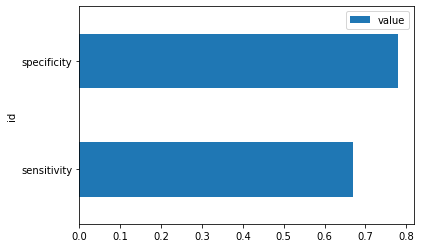

In [69]:
custom_metrics_pandas = subscription.monitoring.get_table_content(monitor_uid=monitor_uid)

%matplotlib inline
custom_metrics_pandas.plot.barh(x='id', y='value');

# Payload analytics <a name="analytics"></a>

## Run data distributions calculation

In [70]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['predictedLabel', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run 686103fc-e9f0-4cd8-8380-99d7bb133bf0 




running
completed

---------------------------
 Successfully finished run 
---------------------------




## Get data distributions as pandas dataframe

In [71]:
sex_distribution_run_uid = sex_distribution['id']
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

,predictedLabel,Sex,count
0,No Risk,female,68
1,No Risk,male,85
2,Risk,female,7
3,Risk,male,48


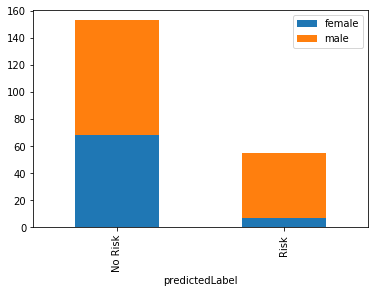

In [72]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

In [73]:
credit_history_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['predictedLabel', 'CreditHistory'],
            agg=['count'])




 Waiting for end of data distribution run fed37df9-513f-4987-85c3-54c76af96bac 




running
completed

---------------------------
 Successfully finished run 
---------------------------




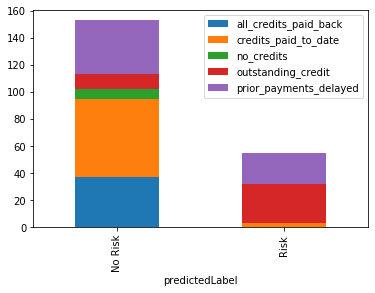

In [74]:
credit_history_distribution_run_uid = credit_history_distribution['id']

subscription.payload_logging.data_distribution.show_chart(credit_history_distribution_run_uid);

# Historical data <a name="historical"></a>

 ## Insert historical payloads

The next section of the notebook downloads and writes historical data to the payload and measurement tables to simulate a production model that has been monitored and receiving regular traffic for the last seven days. This historical data can be viewed in the Watson OpenScale user interface. The code uses the Python and REST APIs to write this data.

In [75]:
!rm history_payloads*.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_0.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_1.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_2.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_3.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_4.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_5.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_6.json

rm: cannot remove 'history_payloads*.json': No such file or directory
--2019-06-05 09:53:11--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_0.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9569926 (9.1M) [text/plain]
Saving to: 'history_payloads_0.json'

history_payloads_0. 100%[===================>]   9.13M  --.-KB/s    in 0.1s    

2019-06-05 09:53:12 (65.6 MB/s) - 'history_payloads_0.json' saved [9569926/9569926]

--2019-06-05 09:53:12--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (r

In [76]:
historyDays = 7

In [77]:
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
import datetime
import time

for day in range(historyDays):
    print('Loading day {}'.format(day + 1))
    history_file = 'history_payloads_' + str(day) + '.json'
    with open(history_file) as f:
        payloads = json.load(f)
        hourly_records = int(len(payloads) / 24)
        index = 0
        for hour in range(24):
            recordsList = []
            for i in range(hourly_records):
                score_time = str(datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1))))
                recordsList.append(PayloadRecord(request=payloads[index]['request'], response=payloads[index]['response'], scoring_timestamp=score_time))
                index += 1
            subscription.payload_logging.store(records=recordsList)
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


In [78]:
data_mart_id = subscription.get_details()['metadata']['url'].split('/service_bindings')[0].split('marts/')[1]
print(data_mart_id)

cacaf1bc-1285-46da-ba9a-49464bc683a3


In [79]:
performance_metrics_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/metrics'
print(performance_metrics_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/cacaf1bc-1285-46da-ba9a-49464bc683a3/metrics


## Insert historical fairness metrics

In [80]:
!rm history_fairness.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_fairness.json

rm: cannot remove 'history_fairness.json': No such file or directory
--2019-06-05 09:54:10--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_fairness.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562458 (549K) [text/plain]
Saving to: 'history_fairness.json'

history_fairness.js 100%[===================>] 549.28K  --.-KB/s    in 0.02s   

2019-06-05 09:54:10 (30.7 MB/s) - 'history_fairness.json' saved [562458/562458]



In [81]:
with open('history_fairness.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    metrics = []
    
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed
        
        metric = {
            'metric_type': 'fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }
        metrics.append(metric)
    response = requests.post(performance_metrics_url, json=metrics, headers=ai_client._get_headers())
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical debias metrics

In [82]:
!rm history_debias.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_debias.json

rm: cannot remove 'history_debias.json': No such file or directory
--2019-06-05 09:54:12--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_debias.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565971 (553K) [text/plain]
Saving to: 'history_debias.json'

history_debias.json 100%[===================>] 552.71K  --.-KB/s    in 0.04s   

2019-06-05 09:54:13 (14.7 MB/s) - 'history_debias.json' saved [565971/565971]



In [83]:
with open('history_debias.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    debias_metrics = []
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed

        debiasMetric = {
            'metric_type': 'debiased_fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }

        debias_metrics.append(debiasMetric)
    response = requests.post(performance_metrics_url, json=debias_metrics, headers=ai_client._get_headers())
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical quality metrics

In [84]:
measurements = [0.76, 0.78, 0.68, 0.72, 0.73, 0.77, 0.80]
for day in range(historyDays):
    quality_metrics = []
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        qualityMetric = {
            'metric_type': 'quality',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'quality': measurements[day],
                'threshold': 0.7,
                'metrics': [
                    {
                        'name': 'auroc',
                        'value': measurements[day],
                        'threshold': 0.7
                    }
                ]
            }
        }
        
        quality_metrics.append(qualityMetric)
    
    response = requests.post(performance_metrics_url, json=quality_metrics, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical confusion matrixes

In [85]:
!rm history_quality_metrics.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_quality_metrics.json

rm: cannot remove 'history_quality_metrics.json': No such file or directory
--2019-06-05 09:54:15--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_quality_metrics.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80244 (78K) [text/plain]
Saving to: 'history_quality_metrics.json'

history_quality_met 100%[===================>]  78.36K  --.-KB/s    in 0.005s  

2019-06-05 09:54:16 (15.5 MB/s) - 'history_quality_metrics.json' saved [80244/80244]



In [86]:
measurements_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/measurements'
print(measurements_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/cacaf1bc-1285-46da-ba9a-49464bc683a3/measurements


In [87]:
with open('history_quality_metrics.json') as json_file:
    records = json.load(json_file)
    
for day in range(historyDays):
    index = 0
    measurments = []
    print('Day', day + 1)
    
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')

        measurement = {
            "monitor_definition_id": 'quality',
            "binding_id": subscription.binding_uid,
            "subscription_id": subscription.uid,
            "asset_id": subscription.source_uid,
            'metrics': [records[index]['metrics']],
            'sources': [records[index]['sources']],
            'timestamp': score_time
        }

        measurments.append(measurement)
        index+=1

    response = requests.post(measurements_url, json=measurments, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical performance metrics

In [88]:
for day in range(historyDays):
    performance_metrics = []
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        score_count = random.randint(60, 600)
        score_resp = random.uniform(60, 300)

        performanceMetric = {
            'metric_type': 'performance',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'response_time': score_resp,
                'records': score_count
            }
        }
        performance_metrics.append(performanceMetric)

    response = requests.post(performance_metrics_url, json=performance_metrics, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical manual labeling

In [89]:
manual_labeling_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/manual_labelings'
print(manual_labeling_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/cacaf1bc-1285-46da-ba9a-49464bc683a3/manual_labelings


In [90]:
!rm history_manual_labeling.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_manual_labeling.json

rm: cannot remove 'history_manual_labeling.json': No such file or directory
--2019-06-05 09:54:18--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_manual_labeling.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 947956 (926K) [text/plain]
Saving to: 'history_manual_labeling.json'

history_manual_labe 100%[===================>] 925.74K  --.-KB/s    in 0.04s   

2019-06-05 09:54:18 (24.4 MB/s) - 'history_manual_labeling.json' saved [947956/947956]



In [91]:
with open('history_manual_labeling.json', 'r') as history_file:
    records = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    record_json = []
    for hour in range(24):
        for record in records:
            if record['fastpath_history_day'] == day and record['fastpath_history_hour'] == hour:
                record['binding_id'] = binding_uid
                record['subscription_id'] = model_uid
                record['asset_revision'] = model_uid
                record['deployment_id'] = deployment_uid
                record['scoring_timestamp'] = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
                record_json.append(record)
    response = requests.post(manual_labeling_url, json=record_json, headers=ai_client._get_headers())

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Additional data to help debugging

In [92]:
print('Datamart:', data_mart_id)
print('Model:', model_uid)
print('Deployment:', deployment_uid)
print('Binding:', binding_uid)
print('Scoring URL:', credit_risk_scoring_endpoint)

Datamart: cacaf1bc-1285-46da-ba9a-49464bc683a3
Model: 1516b304-44cb-4950-bc67-827ad7f219f3
Deployment: 280ac486-14a8-4d4a-95ca-0950498b0523
Binding: a73bf76d-a663-448a-b771-4f651f73d54e
Scoring URL: https://us-south.ml.cloud.ibm.com/v3/wml_instances/a73bf76d-a663-448a-b771-4f651f73d54e/deployments/280ac486-14a8-4d4a-95ca-0950498b0523/online


## Identify transactions for Explainability

Transaction IDs identified by the cells below can be copied and pasted into the Explainability tab of the OpenScale dashboard.

In [93]:
payload_data = subscription.payload_logging.get_table_content(limit=60)
payload_data.filter(items=['scoring_id', 'predictedLabel', 'probability'])

,scoring_id,predictedLabel,probability
0,4fb651304c127cd0a8075037c41519ab-150,No Risk,"[0.6806805993857474, 0.3193194006142525]"
1,4fb651304c127cd0a8075037c41519ab-143,No Risk,"[0.8458456307519402, 0.15415436924805986]"
2,4fb651304c127cd0a8075037c41519ab-15,Risk,"[0.43822167065479595, 0.5617783293452041]"
3,4fb651304c127cd0a8075037c41519ab-118,No Risk,"[0.600914711336521, 0.3990852886634791]"
4,4fb651304c127cd0a8075037c41519ab-132,No Risk,"[0.8619275956502822, 0.13807240434971774]"
5,4fb651304c127cd0a8075037c41519ab-142,No Risk,"[0.9309663448209984, 0.06903365517900159]"
6,4fb651304c127cd0a8075037c41519ab-148,No Risk,"[0.8478288864035715, 0.1521711135964286]"
7,4fb651304c127cd0a8075037c41519ab-149,No Risk,"[0.8404390594997795, 0.1595609405002205]"
8,4fb651304c127cd0a8075037c41519ab-110,Risk,"[0.48550738214490624, 0.5144926178550937]"
9,4fb651304c127cd0a8075037c41519ab-117,Risk,"[0.05754235960075609, 0.942457640399244]"


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.

## Next steps

OpenScale shows model performance over time. You have two options to keep data flowing to your OpenScale graphs:
  * Download, configure and schedule the [model feed notebook](https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_scoring_feed.ipynb). This notebook can be set up with your WML credentials, and scheduled to provide a consistent flow of scoring requests to your model, which will appear in your OpenScale monitors.
  * Re-run this notebook. Running this notebook from the beginning will delete and re-create the model and deployment, and re-create the historical data. Please note that the payload and measurement logs for the previous deployment will continue to be stored in your datamart, and can be deleted if necessary.

## Authors

Eric Martens, is a technical specialist having expertise in analysis and description of business processes, and their translation into functional and non-functional IT requirements. He acts as the interpreter between the worlds of IT and business.

Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.